# Score Function Notebook

This notebook performs all the required tests for the NFL 2022 score function. 


# 0. Load Libraries and Preprocess Data

In [1]:
import os
import re
import sys
import tqdm
import numpy as np
import pandas as pd
import scipy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation

import random
import seaborn as sns

# Libraries required for plotting field
import matplotlib.patches as patches
from matplotlib.patches import Arc
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import animation
from IPython.display import HTML
from IPython import display


# Custom libraries
sys.path.append('../')
from src.utils.feature_extraction import extract_play_outcome_features, extract_formation_features, extract_foul_features, extract_injury_features, extract_game_features
from definitions.fouls_def import ignore_fouls
from src.utils.viz_functions import drawPitch, drawPocket, animatePlay_Generic, animateScores
from src.utils.play_preprocessing import extractPlay, preprocessPlay_refBallInit, preprocessPlay_refQB, preprocessPlay_refQB_NFrames

In [22]:
# Define input parameters
input_path = '../input'
preprocessing_path = '../processing'

config = {
    # Preprocessing Play parameters
    # 'preprocess_funct': preprocessPlay_refLineScrimmageInit,
    'hold_QB_ref': 20,
    'post_snap_time': 8,

    # Pocket parameters
    'pocket_len': 15.0,
    'pocket_res': 0.1,

    # Field Price parameters
    'pocket_linear_max_value': 1.0,
    'pocket_gaus_mu': 0.0,
    'pocket_gaus_sigma': 2.0,
    # 'field_price_funct': gaussian_field_price,

    # Player Influence parameters
    'gaus_mu': 0.0,
    'gaus_sigma': 2.0,
    # 'player_infl_funct': gaussian_player_influence_score
}

In [3]:
# Load one of the 8 week datasets - i.e. week1
week1_data = pd.read_csv(os.path.join(input_path, 'week1.csv'))
week1_data.head(5)

,gameId,playId,nflId,frameId,time,jerseyNumber,team,playDirection,x,y,s,a,dis,o,dir,event
0,2021090900,97,25511.0,1,2021-09-10T00:26:31.100,12.0,TB,right,37.77,24.22,0.29,0.30,0.03,165.16,84.99,None
1,2021090900,97,25511.0,2,2021-09-10T00:26:31.200,12.0,TB,right,37.78,24.22,0.23,0.11,0.02,164.33,92.87,None
2,2021090900,97,25511.0,3,2021-09-10T00:26:31.300,12.0,TB,right,37.78,24.24,0.16,0.10,0.01,160.24,68.55,None
3,2021090900,97,25511.0,4,2021-09-10T00:26:31.400,12.0,TB,right,37.73,24.25,0.15,0.24,0.06,152.13,296.85,None
4,2021090900,97,25511.0,5,2021-09-10T00:26:31.500,12.0,TB,right,37.69,24.26,0.25,0.18,0.04,148.33,287.55,None


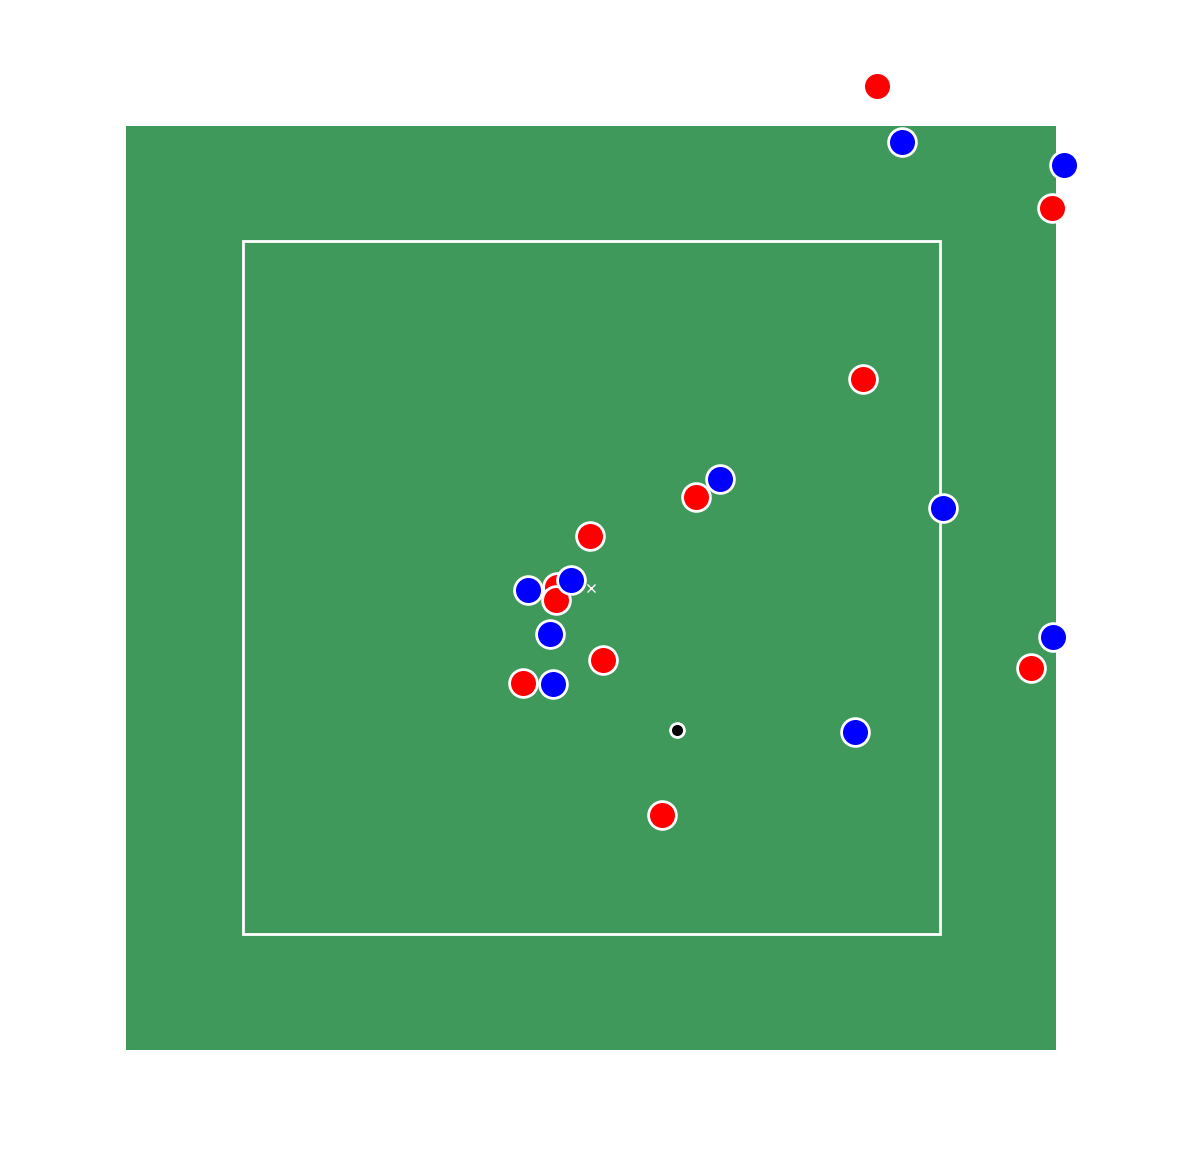

In [4]:
# Define Game & Play ID and pre-process
gameId = "2021090900"
playId = "97"

# Extract info from the play
team1, team2, ball = extractPlay(week1_data, gameId, playId)
team1, team2, ball = preprocessPlay_refQB_NFrames(team1, team2, ball, delay_frame=config['hold_QB_ref'], post_snap_time=config['post_snap_time'])

# Plot the play
animatePlay_Generic(team1, team2, ball, drawPocket(), store_path=f"../videos/{gameId}_{playId}_pocket.mp4")

# 1. Player Influence Calculation

We start by testing the function to generate the player influence

In [5]:
# Function applied to players - Gaussian Distribution function
def gaussian_player_influence_score(player_x, player_y, pixel_x, pixel_y):

    # Determine the relative position of the pixel from the player
    X = player_x - pixel_x
    Y = player_y - pixel_y

    # Calculate Gaussian Distribution
    R = np.sqrt(X**2 + Y**2)
    Z = np.exp(-( (R-config['gaus_mu'])**2 / ( 2.0 * config['gaus_sigma']**2 ) ) )
    
    return Z

In [6]:
def test_player_score_funct():

  domain = 6
  mean = 0
  variance = 0.1
  x = np.arange(-domain+mean, domain+mean, variance)
  y = np.arange(-domain+mean, domain+mean, variance)
  x, y = np.meshgrid(x, y)


  z = gaussian_player_influence_score(
    player_x=1,
    player_y=1,
    pixel_x=x,
    pixel_y=y
  )

  fig = plt.figure(figsize=(12, 6))
  ax = fig.gca(projection='3d')
  ax.plot_surface(x, y, z, 
                  cmap=matplotlib.cm.coolwarm,
                  linewidth=0, 
                  antialiased=True)
  ax.set_xlabel('x')
  ax.set_ylabel('y')
  ax.set_zlabel('z');
  plt.show()

/var/folders/r1/qr8wrlpd13x_x7s4br12s4bm0000gn/T/ipykernel_12149/1333608351.py:19: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


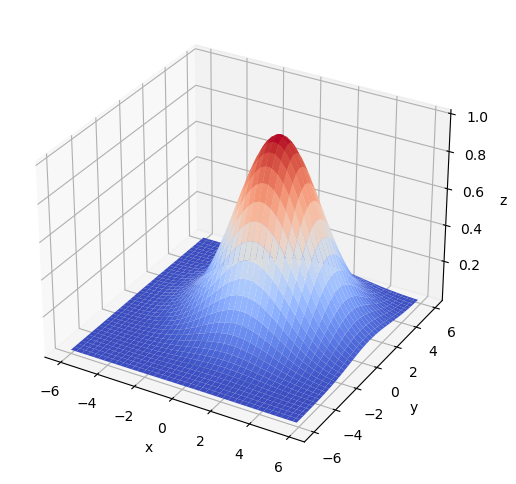

In [7]:
test_player_score_funct()

We can now integrate this scoring function into the wider field

In [8]:
def calculate_grid_score(pixel_x, pixel_y, frameId, team_def, infl_funct):

    # Extract frame information
    defense = team_def.loc[team_def.frameId == frameId]
        
    # For each player, obtain the score
    dimensions = pixel_x.shape
    frame_scores = np.zeros((dimensions[0], dimensions[1], len(defense)))
    for idx,(_, def_player) in enumerate(defense.iterrows()):
        
        frame_scores[:,:,idx] = infl_funct(
            player_x=def_player.x,
            player_y=def_player.y,
            pixel_x=pixel_x,
            pixel_y=pixel_y
        )

    # At the end of this calculation, only maintain the maximum one
    return frame_scores.max(axis=2)
    


In [9]:
# Let's imagine we do this for frame 5
frameId = 5

# Create a mesh of values
pocket_pos_start = -(config['pocket_len']/2)
pocket_pos_end = (config['pocket_len']/2)
x = np.arange(pocket_pos_start, pocket_pos_end, config['pocket_res'])
y = np.arange(pocket_pos_start, pocket_pos_end, config['pocket_res'])
x, y = np.meshgrid(x, y)

scores = calculate_grid_score(x, y, frameId, team_def=team2, infl_funct=gaussian_player_influence_score)

In [10]:
animateScores(scores.reshape(1, 300,300))

ValueError: cannot reshape array of size 22500 into shape (1,300,300)

Now that we know the function works, let's integrate it with all frames

In [12]:
def extract_play_players_influence(team_def, infl_funct):

    # Create a mesh of values
    pocket_pos_start = -(config['pocket_len']/2)
    pocket_pos_end = (config['pocket_len']/2)
    x = np.arange(pocket_pos_start, pocket_pos_end, config['pocket_res'])
    y = np.arange(pocket_pos_start, pocket_pos_end, config['pocket_res'])
    x, y = np.meshgrid(x, y)

    num_frames = team_def.frameId.max()
    array_dimension = x.shape
    scores = np.empty((num_frames, array_dimension[0], array_dimension[1]))
    for frame in range(num_frames):
        scores[frame, :, :] = calculate_grid_score(x, y, frame+1, team_def=team_def, infl_funct=infl_funct)

    return scores

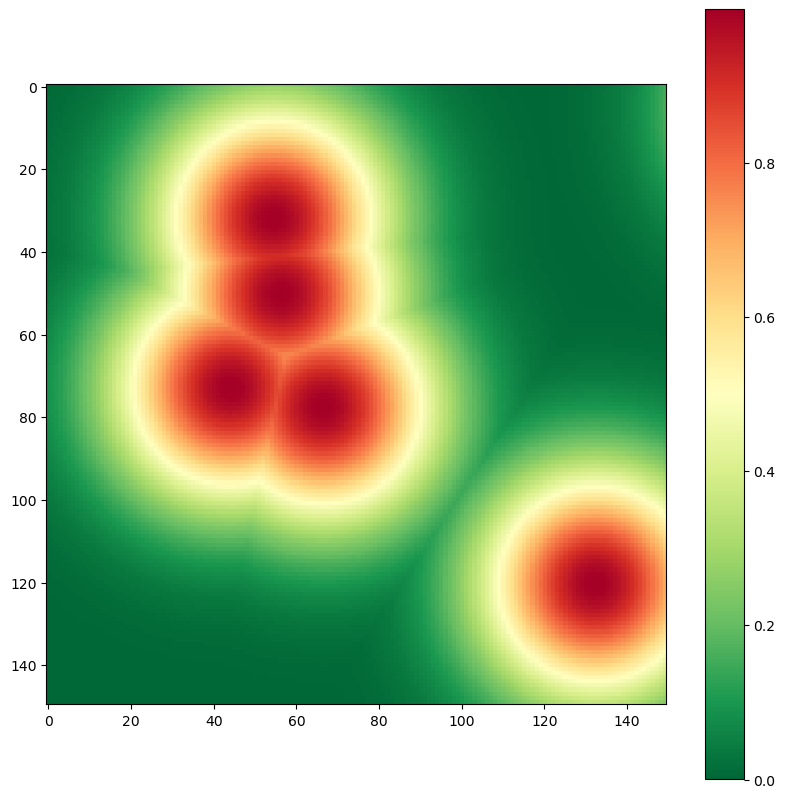

In [13]:
players_influence = extract_play_players_influence(team2, infl_funct=gaussian_player_influence_score)
animateScores(players_influence)

# 2. Field Price Calculation
Next step is to create the field scoring based on a provided function

In [14]:
# Function applied to field - Gaussian Distribution function
def gaussian_field_price(pixel_x, pixel_y):

    # Calculate Gaussian Distribution
    R = np.sqrt(pixel_x**2 + pixel_y**2)
    Z = np.exp(-( (R-config['pocket_gaus_mu'])**2 / ( 2.0 * config['pocket_gaus_sigma']**2 ) ) )
    
    return Z

In [15]:
def linear_field_price(pixel_x, pixel_y):

    # Calculate slope
    slope = (config['pocket_linear_max_value'] - 0) / (0 - (-config['pocket_len']/2))

    # Calculate Linear Distribution
    R = np.sqrt(pixel_x**2 + pixel_y**2)
    Z = 1 - slope * R
    Z[Z<0] = 0

    return Z

In [16]:
# Create a mesh of values
pocket_pos_start = -(config['pocket_len']/2)
pocket_pos_end = (config['pocket_len']/2)
x = np.arange(pocket_pos_start, pocket_pos_end, config['pocket_res'])
y = np.arange(pocket_pos_start, pocket_pos_end, config['pocket_res'])
x, y = np.meshgrid(x, y)

field_price = linear_field_price(x, y)

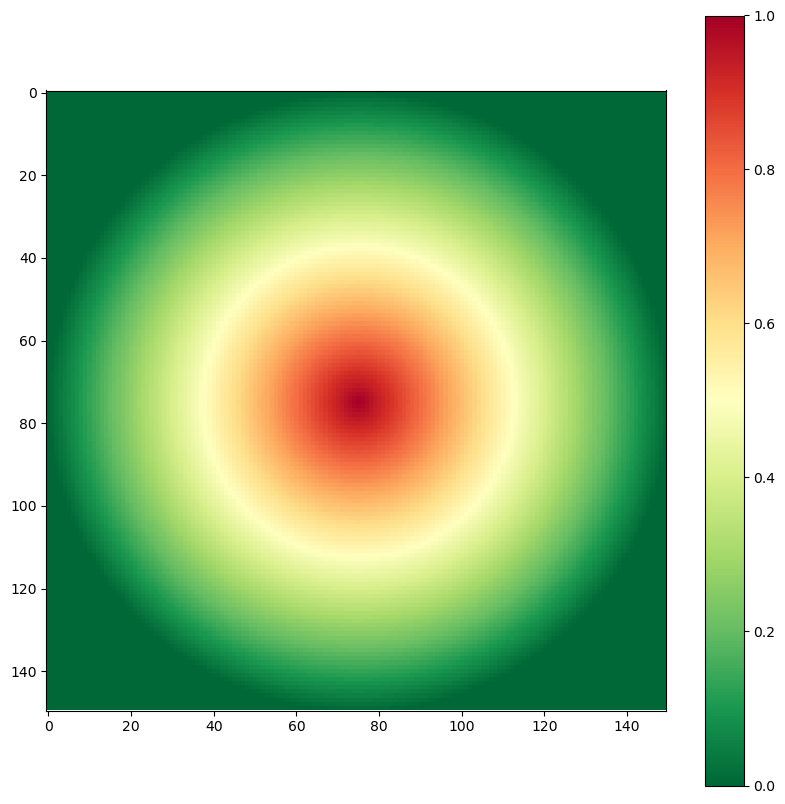

In [19]:
animateScores(field_price.reshape(1, 150,150))

In [23]:
# Create a mesh of values
pocket_pos_start = -(config['pocket_len']/2)
pocket_pos_end = (config['pocket_len']/2)
x = np.arange(pocket_pos_start, pocket_pos_end, config['pocket_res'])
y = np.arange(pocket_pos_start, pocket_pos_end, config['pocket_res'])
x, y = np.meshgrid(x, y)

field_price = gaussian_field_price(x, y)

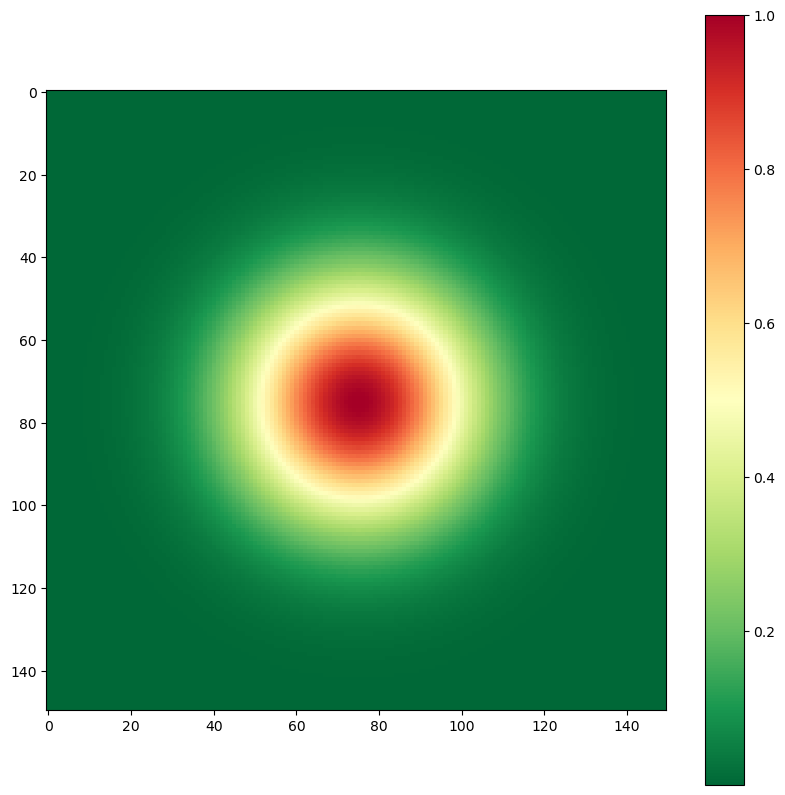

In [24]:
animateScores(field_price.reshape(1, 150,150))

In [20]:
def calculate_field_price(price_funct, config):

    # Create a mesh of values
    pocket_pos_start = -(config['pocket_len']/2)
    pocket_pos_end = (config['pocket_len']/2)
    x = np.arange(pocket_pos_start, pocket_pos_end, config['pocket_res'])
    y = np.arange(pocket_pos_start, pocket_pos_end, config['pocket_res'])
    x, y = np.meshgrid(x, y)


    # Perform price calculation
    return price_funct(x, y)

# 3. Final Score Calculation

In [21]:
# Extract player influence
players_influence = extract_play_players_influence(team2, infl_funct=gaussian_player_influence_score)

# Extract field price
field_price = calculate_field_price(price_funct=gaussian_field_price, config=config)

In [22]:
frames_scores = np.sum(np.sum(np.multiply(players_influence, field_price), axis=2), axis=1)

Text(0.5, 1.0, 'Score over time')

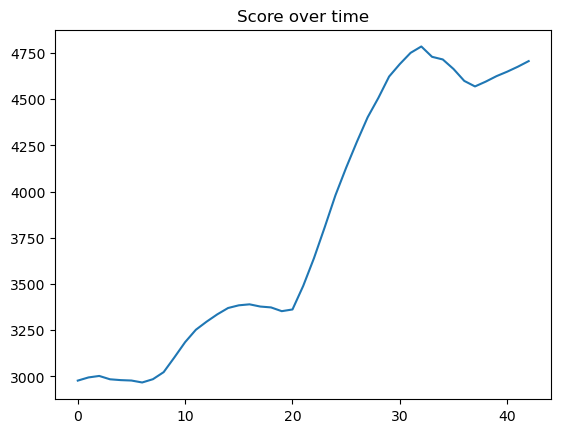

In [23]:
plt.plot(frames_scores)
plt.title("Score over time")